# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# eventual initialization for collab notebooks
if IN_COLAB:
  # we try hard to be re-entrant,
  # that is to be able to rerun this without cloning repository more than once
  COLAB_BRANCH = "master"
  !curl https://raw.githubusercontent.com/openfoodfacts/off-category-classification/$COLAB_BRANCH/lib/colab.py --output /content/colab.py
  !cd /content && python /content/colab.py $COLAB_BRANCH
  %cd /content/off-category-classification/experiments

In [2]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
tracker.start()

[codecarbon ERROR @ 09:39:24] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 09:39:24] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon ERROR @ 09:39:25] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 09:39:25] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/

# Imports

In [3]:
import sys
sys.path.append('../') # append a relative path to the top package to the search path

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.eval import top_predictions
from lib.io import load_training_model, load_serving_model, save_model_bundle
from lib.plot import plot_training_stat

2022-06-11 09:39:29.066530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 09:39:29.066549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/alex/docker/off-category-classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [5]:
MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[:80%]'
VAL_SPLIT = 'train[80%:90%]'
TEST_SPLIT = 'train[90%:]'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [6]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [7]:
tf.random.set_seed(42)

# Taxonomy information

In [9]:
import json
from lib.taxonomy import Taxonomy
! ls category_taxonomy.json || wget https://github.com/openfoodfacts/robotoff-models/releases/download/keras-category-classifier-xx-2.0/category_taxonomy.json

taxo = Taxonomy.from_data(json.load(open('category_taxonomy.json')))

category_taxonomy.json


## Model inputs

In [10]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [11]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

2022-06-11 09:39:57.572175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-11 09:39:57.572205: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-11 09:39:57.572236: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tignasse): /proc/driver/nvidia/version does not exist
2022-06-11 09:39:57.572594: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

2022-06-11 09:39:57.799351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 43.4 s, sys: 13.8 s, total: 57.2 s
Wall time: 10.7 s


93000

In [13]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 59.6 s, sys: 18.3 s, total: 1min 17s
Wall time: 12.8 s


5000

## Model output

In [14]:
%%time

from lib.dataset import filter_empty_labels, get_vocabulary, flat_batch, select_feature

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# intersect with taxonomy vocab
categories_vocab = taxo.cats_filter(categories_vocab)


# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)



len(categories_vocab)

CPU times: user 57.9 s, sys: 18.9 s, total: 1min 16s
Wall time: 12.6 s


4023

In [15]:
def add_ancestors(ds: tf.data.Dataset):
    """Add ancestors to y to be sure to have coherent data"""

    def get_ancestors(cats):
      cats_list = [c.decode("utf-8") for c in cats.numpy()]
      result = list(taxo.cats_complete(taxo.cats_filter(cats_list)))
      return tf.constant(result, dtype=tf.string)

    def _transform(x, y):
        y = tf.py_function(func=get_ancestors, inp=[y], Tout=tf.string)
        # make shape clear to avoid failing at compile time on next steps
        y = tf.reshape(y, [-1])
        return (x, y)
    # apply to dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    )

In [16]:
def add_compatible_categories(ds: tf.data.Dataset):
    """Add a specific feature with compatible categories"""

    def get_compat(cats):
      cats_list = [c.decode("utf-8") for c in cats.numpy()]
      result = list(taxo.cats_compat(taxo.cats_filter(cats_list)))
      return tf.constant(result, dtype=tf.string)

    def _transform(x, y):
        x["compat"] = tf.py_function(func=get_compat, inp=[y], Tout=tf.string)
        # make shape clear to avoid failing at compile time on next steps
        x["compat"] = tf.reshape(x["compat"], [-1])
        return (x, y)
    # apply to dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    )

In [17]:
def categories_encode(ds: tf.data.Dataset):
    """encode categories
    
    - as multi-hot for y
    - as a mask for "compat" feature
    """

    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        if "compat" in x:
          # vector where compat categories are 1
          binarized = categories_multihot(x["compat"])
          binarized = binarized[1:]  # drop OOV
          # make it a mask where compatibles are 0, the rest one
          binarized = tf.ones(binarized.shape, dtype=tf.float32) - binarized
          # make a new ds (we can't modify current x)
          x = dict(
            x,
            compat=binarized,
          )
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )


## Model

In [18]:
class MaskingModel(tf.keras.Model):
  """A model that applies a mask taken 
  from features to y_pred before computing loss
  """

  def __init__(self, *args, mask_feature="compat", **kwargs):
    super().__init__(*args, **kwargs)
    self.mask_feature = mask_feature

  def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
    # first mask categories we do not want using the compat feature
    mask = x[self.mask_feature]
    # zeros mask_feature in y_pred, as we know they are not in y_pred
    y_pred *= mask
    return super().compute_loss(x, y, y_pred, sample_weight)

In [26]:
%%time
# mask input 

feature_name = 'compat'

mask_input = tf.keras.Input(shape=(len(categories_vocab),), dtype=tf.float32, name=feature_name)

CPU times: user 3.03 ms, sys: 0 ns, total: 3.03 ms
Wall time: 3.05 ms


In [32]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)
# apply mask
output = layers.Multiply()((output, mask_input))

model = tf.keras.Model(inputs=[inputs[k] for k in features] + [mask_input], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 30)           0           product_name[0][0]               
__________________________________________________________________________________________________
ingredients_tags (InputLayer)   [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       5952000     text_vectorization[0][0]         
____________________________________________________________________________________________

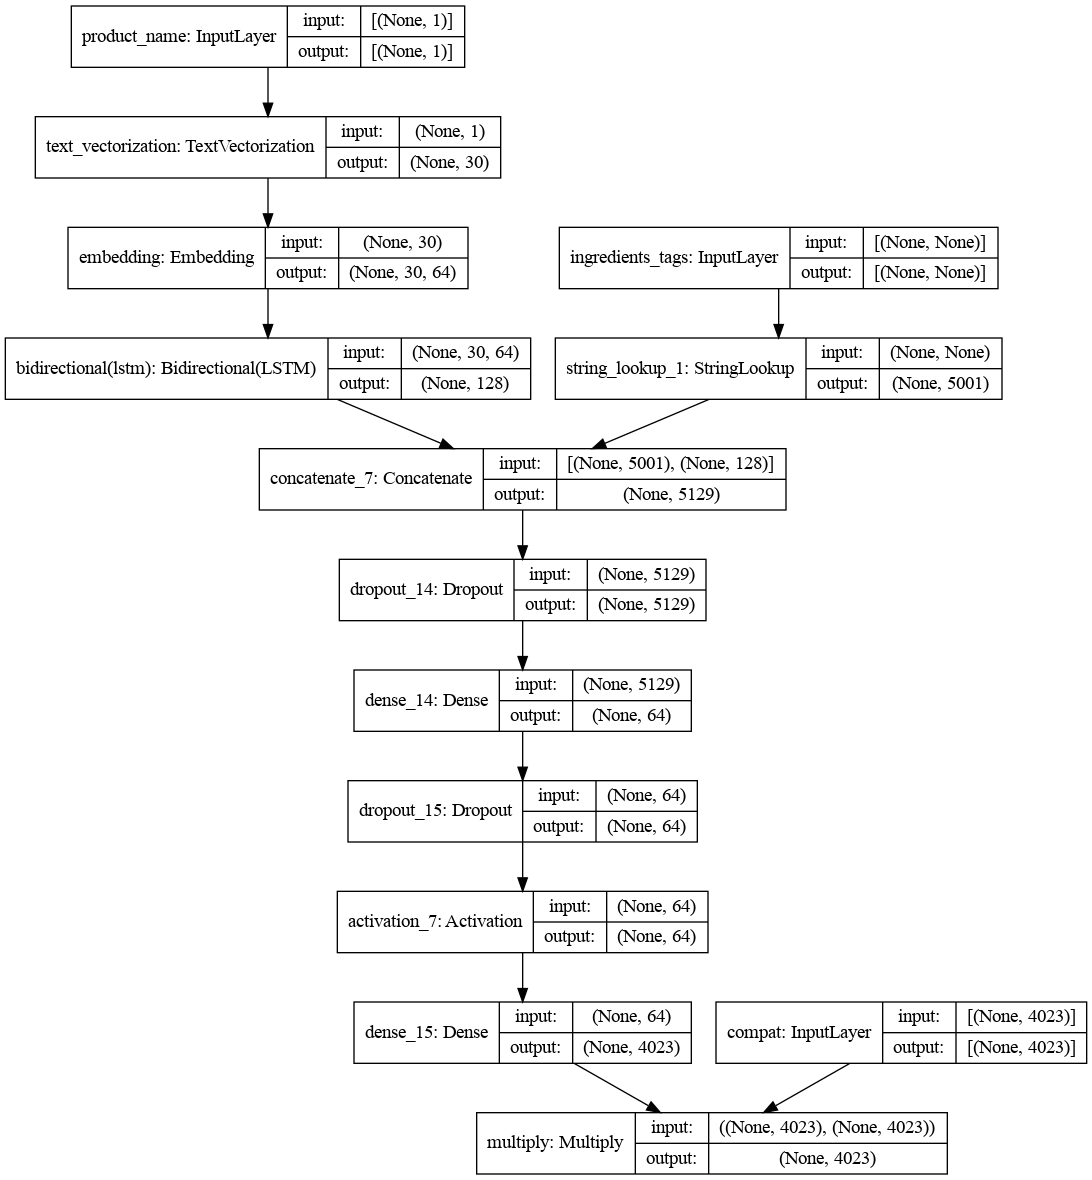

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [35]:
# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

Model directory: ../model.20220611-094845
Cache directory: ../tensorflow_cache


In [ ]:
%%time

history = model.fit(
    ds_train,
    epochs = 50,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

2022-06-11 09:48:49.245250: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/50
   4808/Unknown - 4486s 932ms/step - loss: 0.0084 - binary_accuracy: 0.9985 - precision: 0.1597 - recall: 0.0607

## Save model and resources

In [ ]:
save_model_bundle(MODEL_DIR, model, categories_vocab)

## Training stats

In [ ]:
from pathlib import Path
MODEL_DIR =  Path("../model.20220610-094814")

In [ ]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_training_stat(stats, 'loss', ax1)
plot_training_stat(stats, 'binary_accuracy', ax2)

# Test model

In [ ]:
training_model = load_training_model(MODEL_DIR)
serving_model = load_serving_model(MODEL_DIR)

In [ ]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

## Predict with training model

In [ ]:
%%time

training_pred_test = training_model.predict(ds_test.padded_batch(128))

print(training_pred_test.shape)
training_pred_test

## Predict with serving model

In [ ]:
%%time

serving_pred_test = serving_model.predict(ds_test.padded_batch(128))

serving_pred_test

In [ ]:
%%time

test_top_predictions = top_predictions(ds_test, serving_pred_test, 4)

In [ ]:
# codecarbon - stop tracking
tracker.stop()